In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from dataset import EEG
import wandb
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
# Now do your import
from config import *
 
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from mne.decoding import CSP
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle

In [2]:
# home directory + datasets folder
#C:\Users\Pongk\Desktop\Work\mi-project\EEG-python\dataset\recorded_EEG
path = RECORED_PATH
#path = "/root/EEG_Model/dataset/finetune_EEG/"
#subject to run
#runs = [2,3,4,6,8,12,15,17,18,22]
left_runs = [4,6,8,10,12,3,5,7,9,11]
right_runs = [4,6,8,10,12,3,5,7,9,11]

#[3,5,7,9,11]
#[4,6,8,10,12]
subjects = [21]
#recorded eeg class
left_eeg = EEG(path, subjects, left_runs)
raw=left_eeg.data_to_raw()
right_eeg = EEG(path, subjects, right_runs)
right_raw = right_eeg.data_to_raw()

print("Raw done")
# apply filter 
iir_param = dict(order=5, ftype='butter', output='sos')
raw=raw.notch_filter([50])
#raw = raw.filter(8,13, method='fir', verbose=20)
raw=raw.filter(8,14,method = 'iir',iir_params=iir_param,phase='zero')
right_raw=right_raw.notch_filter([50])
#right_raw= right_raw.filter(8,13, method='fir', verbose=20)
right_raw=right_raw.filter(8,14,method = 'iir',iir_params=iir_param,phase='zero')
#raw.filter(8,13, method='fir', verbose=20)
print("Filter done")

raw = left_eeg.pickChannel(raw,['T3','C3','C4','T4','STIM MARKERS'])
right_raw = right_eeg.pickChannel(right_raw,['T3','C3','C4','T4','STIM MARKERS'])
#raw=eeg.raw_ica()
#eeg.create_epochs()
    

/Users/pongkornsettasompop/Desktop/work/Motor-Imagery/EEG-python/dataset/recorded_EEG
/Users/pongkornsettasompop/Desktop/work/Motor-Imagery/EEG-python/dataset/recorded_EEG
Raw done
Filtering raw data in 10 contiguous segments
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

In [3]:
#X = X[:, :,np.newaxis,:]
# X,y = eeg.raw_preprocess(raw)
# #(250*5)
#X = X[:,:,(250*3):]
#print(X.shape)
# #X = X[:, :,np.newaxis,:]
epochs=left_eeg.epochs(raw,tmin=-3,tmax=5,event_id=[1],baseline=(-3,0))
X_l, y_l = left_eeg.get_X_y(epochs)
#X_l = left_eeg.apply_CSP(X_l,y_l)
#print(X_l.shape)
#print(y_l)

r_epochs=right_eeg.epochs(right_raw,tmin=-3,tmax=5,event_id=[2],baseline=(-3,0))
X_r, y_r = right_eeg.get_X_y(r_epochs)
#X_r = right_eeg.apply_CSP(X_r,y_r)
#print(X_r.shape)
#print(y_r)

X = np.concatenate((X_l,X_r),axis=0)
y = np.concatenate((y_l,y_r),axis=0)
X = right_eeg.apply_CSP(X,y)
print(X.shape,y.shape)

Computing rank from data with rank=None
    Using tolerance 4 (2.2e-16 eps * 4 dim * 4.5e+15  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.9 (2.2e-16 eps * 4 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
(200, 4) (200,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print('Train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)
print(y_train)
print(y_test)

Train size (140, 4) (140,)
Test size (60, 4) (60,)
[1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1
 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 0
 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0
 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0]
[0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0
 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0]


0.5642857142857143
Test acc:  0.5166666666666667


0.48333333333333334

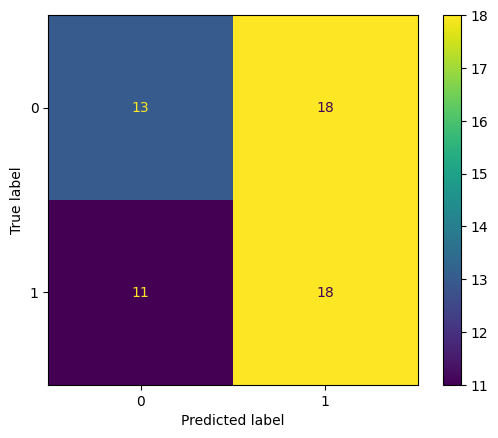

In [5]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Test acc: ", accuracy_score(y_test, y_pred))

pkl_filename = "svm_SO21_all.pk"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)


confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
mean_squared_error(y_test, y_pred)

0.5857142857142857
Test acc:  0.5666666666666667


0.43333333333333335

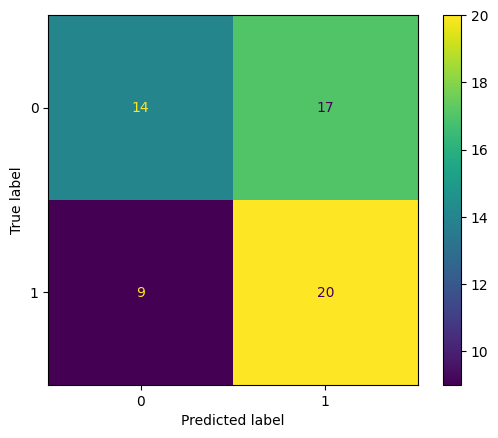

In [6]:
# train LDA classifier
lda = LDA()
lda.fit(X_train, y_train)
print(lda.score(X_train, y_train))
y_hat = lda.predict(X_test)

print("Test acc: ", accuracy_score(y_test, y_hat))
#save
pkl_filename = "lda_SO21_all.pk"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lda, file)


confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
mean_squared_error(y_test, y_hat) 

1.0
Test acc:  0.5


0.5

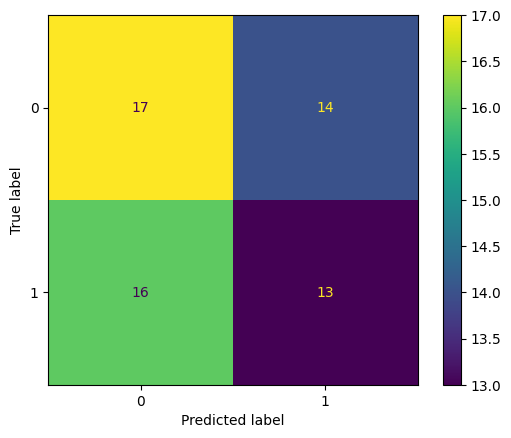

In [7]:
clf = RandomForestClassifier()
score = clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
y_hat = clf.predict(X_test)
print("Test acc: ", accuracy_score(y_test, y_hat))

pkl_filename = "forest_SO21_all.pk"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)


confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
mean_squared_error(y_test, y_hat) 

In [40]:
path = RECORED_PATH
left_runs = [16,18]
right_runs = [15,17]
#[16,18] [15,17]
#[3,5,7,9,11]
#[4,6,8,10,12]
subjects = [21]
#recorded eeg class

left_eeg = EEG(path, subjects, left_runs)
raw=left_eeg.data_to_raw()
right_eeg = EEG(path, subjects, right_runs)
right_raw = right_eeg.data_to_raw()

print("Raw done")
# apply filter 
iir_param = dict(order=5, ftype='butter', output='sos')
raw=raw.notch_filter([50])
raw= raw.filter(8,13, method='fir', verbose=20)
#raw=raw.filter(8,30,method = 'iir',iir_params=iir_param,phase='zero')
right_raw=right_raw.notch_filter([50])
right_raw= right_raw.filter(8,13, method='fir', verbose=20)
#right_raw=right_raw.filter(8,30,method = 'iir',iir_params=iir_param,phase='zero')
#raw.filter(8,13, method='fir', verbose=20)
print("Filter done")

raw = left_eeg.pickChannel(raw,['T3','C3','C4','T4','STIM MARKERS'])
right_raw = right_eeg.pickChannel(right_raw,['T3','C3','C4','T4','STIM MARKERS'])

epochs=left_eeg.epochs(raw,tmin=-3,tmax=5,event_id=[1],baseline=(-3,0))
X_l, y_l = left_eeg.get_X_y(epochs)


r_epochs=right_eeg.epochs(right_raw,tmin=-3,tmax=5,event_id=[2],baseline=(-3,0))
X_r, y_r = right_eeg.get_X_y(r_epochs)


X = np.concatenate((X_l,X_r),axis=0)
y = np.concatenate((y_l,y_r),axis=0)
X = right_eeg.apply_CSP(X,y)
print(X.shape,y.shape)


/Users/pongkornsettasompop/Desktop/work/Motor-Imagery/EEG-python/dataset/recorded_EEG
/Users/pongkornsettasompop/Desktop/work/Motor-Imagery/EEG-python/dataset/recorded_EEG
Raw done
Filtering raw data in 2 contiguous segments
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB st

Test acc:  0.65


0.35

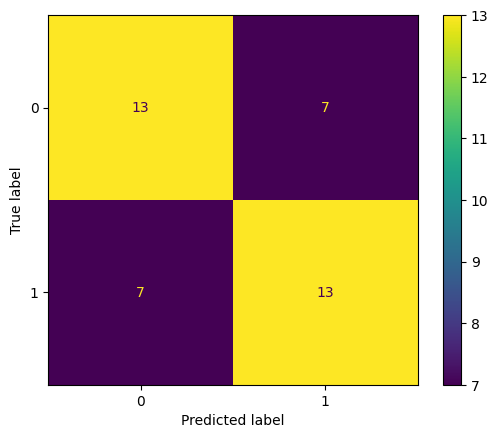

In [41]:
loaded_model = pickle.load(open('svm_SO21_all.pk', 'rb'))
y_hat = loaded_model.predict(X)
print("Test acc: ", accuracy_score(y, y_hat))
confusion_matrix(y, y_hat)
ConfusionMatrixDisplay.from_predictions(y, y_hat)
mean_squared_error(y, y_hat) 
#result = loaded_model.score(X_test, Y_test)

Test acc:  0.775


0.225

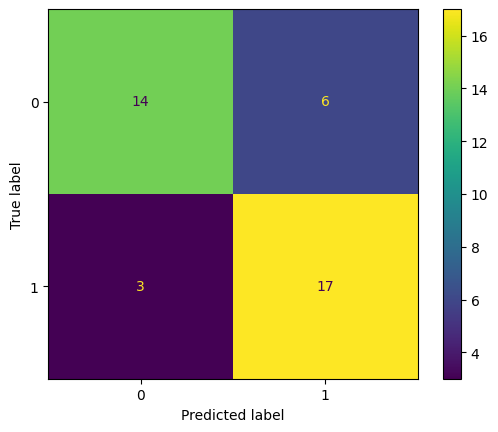

In [42]:
loaded_model = pickle.load(open('lda_SO21_all.pk', 'rb'))
y_hat = loaded_model.predict(X)
print("Test acc: ", accuracy_score(y, y_hat))
confusion_matrix(y, y_hat)
ConfusionMatrixDisplay.from_predictions(y, y_hat)
mean_squared_error(y, y_hat) 

Test acc:  0.6


0.4

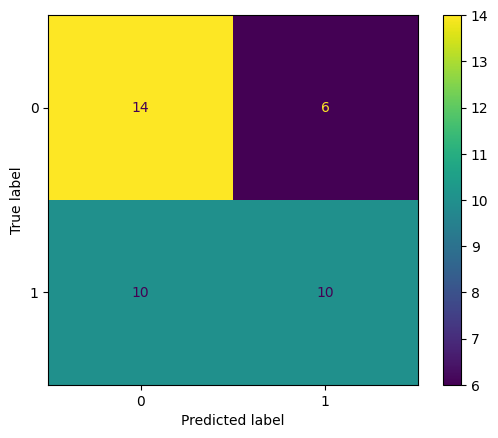

In [43]:
loaded_model = pickle.load(open('forest_SO21_all.pk', 'rb'))
y_hat = loaded_model.predict(X)
print("Test acc: ", accuracy_score(y, y_hat))
confusion_matrix(y, y_hat)
ConfusionMatrixDisplay.from_predictions(y, y_hat)
mean_squared_error(y, y_hat) 